In [97]:

import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

In [ ]:
# Link dataset: https://www.kaggle.com/datasets/aryan208/financial-transactions-dataset-for-fraud-detection

data_frame = pd.read_csv("./datasets/financial-fraud/financial_fraud_detection_dataset.csv")
data_frame = data_frame[data_frame['time_since_last_transaction'] >= 0].copy()

fraud_df = data_frame[data_frame['is_fraud'] == 1]
legit_df = data_frame[data_frame['is_fraud'] == 0]

legit_sample = legit_df.sample(frac=0.036, random_state=42)
data_frame = pd.concat([fraud_df, legit_sample]).reset_index(drop=True)

data_frame.columns

Index(['transaction_id', 'timestamp', 'sender_account', 'receiver_account',
       'amount', 'transaction_type', 'merchant_category', 'location',
       'device_used', 'is_fraud', 'fraud_type', 'time_since_last_transaction',
       'spending_deviation_score', 'velocity_score', 'geo_anomaly_score',
       'payment_channel', 'ip_address', 'device_hash'],
      dtype='object')

transaction_id: Unique identifier for each transaction

timestamp: Date and time when the transaction occurred

sender_account: The account that sends the money

receiver_account: The account that receives the money

amount: The monetary value of the transaction

transaction_type: Type of transaction (e.g., transfer, payment, withdrawal)

merchant_category: Type of merchant or service (e.g., retail, electronics, travel)

location: Geographic location where the transaction happened

device_used: Device used for the transaction (e.g., mobile, computer, ATM)

is_fraud: Indicates if the transaction is fraudulent (1 = fraud, 0 = not fraud)

fraud_type: Type of fraud

time_since_last_transaction: Time difference between this and the previous transaction in hour for the same account

spending_deviation_score: How unusual the transaction amount is compared to the account’s normal spending

velocity_score: How quickly transactions are occurring; high values may indicate unusual rapid activity

geo_anomaly_score: How unusual the location is compared to the account’s typical locations

payment_channel: Method of payment (e.g., online, POS, ATM, mobile)

ip_address: Internet protocol address used for online transactions

device_hash: Unique identifier for the device used, for tracking devices

is_fraud
True     89673
False    70649
Name: count, dtype: int64


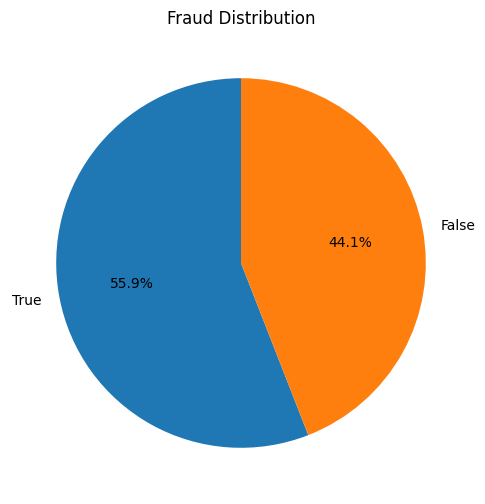

In [99]:
is_fraud = data_frame["is_fraud"].value_counts()

print(is_fraud)

plt.figure(figsize=(6,6))
plt.pie(is_fraud, labels=is_fraud.index, autopct="%1.1f%%", startangle=90)
plt.title("Fraud Distribution")
plt.show()

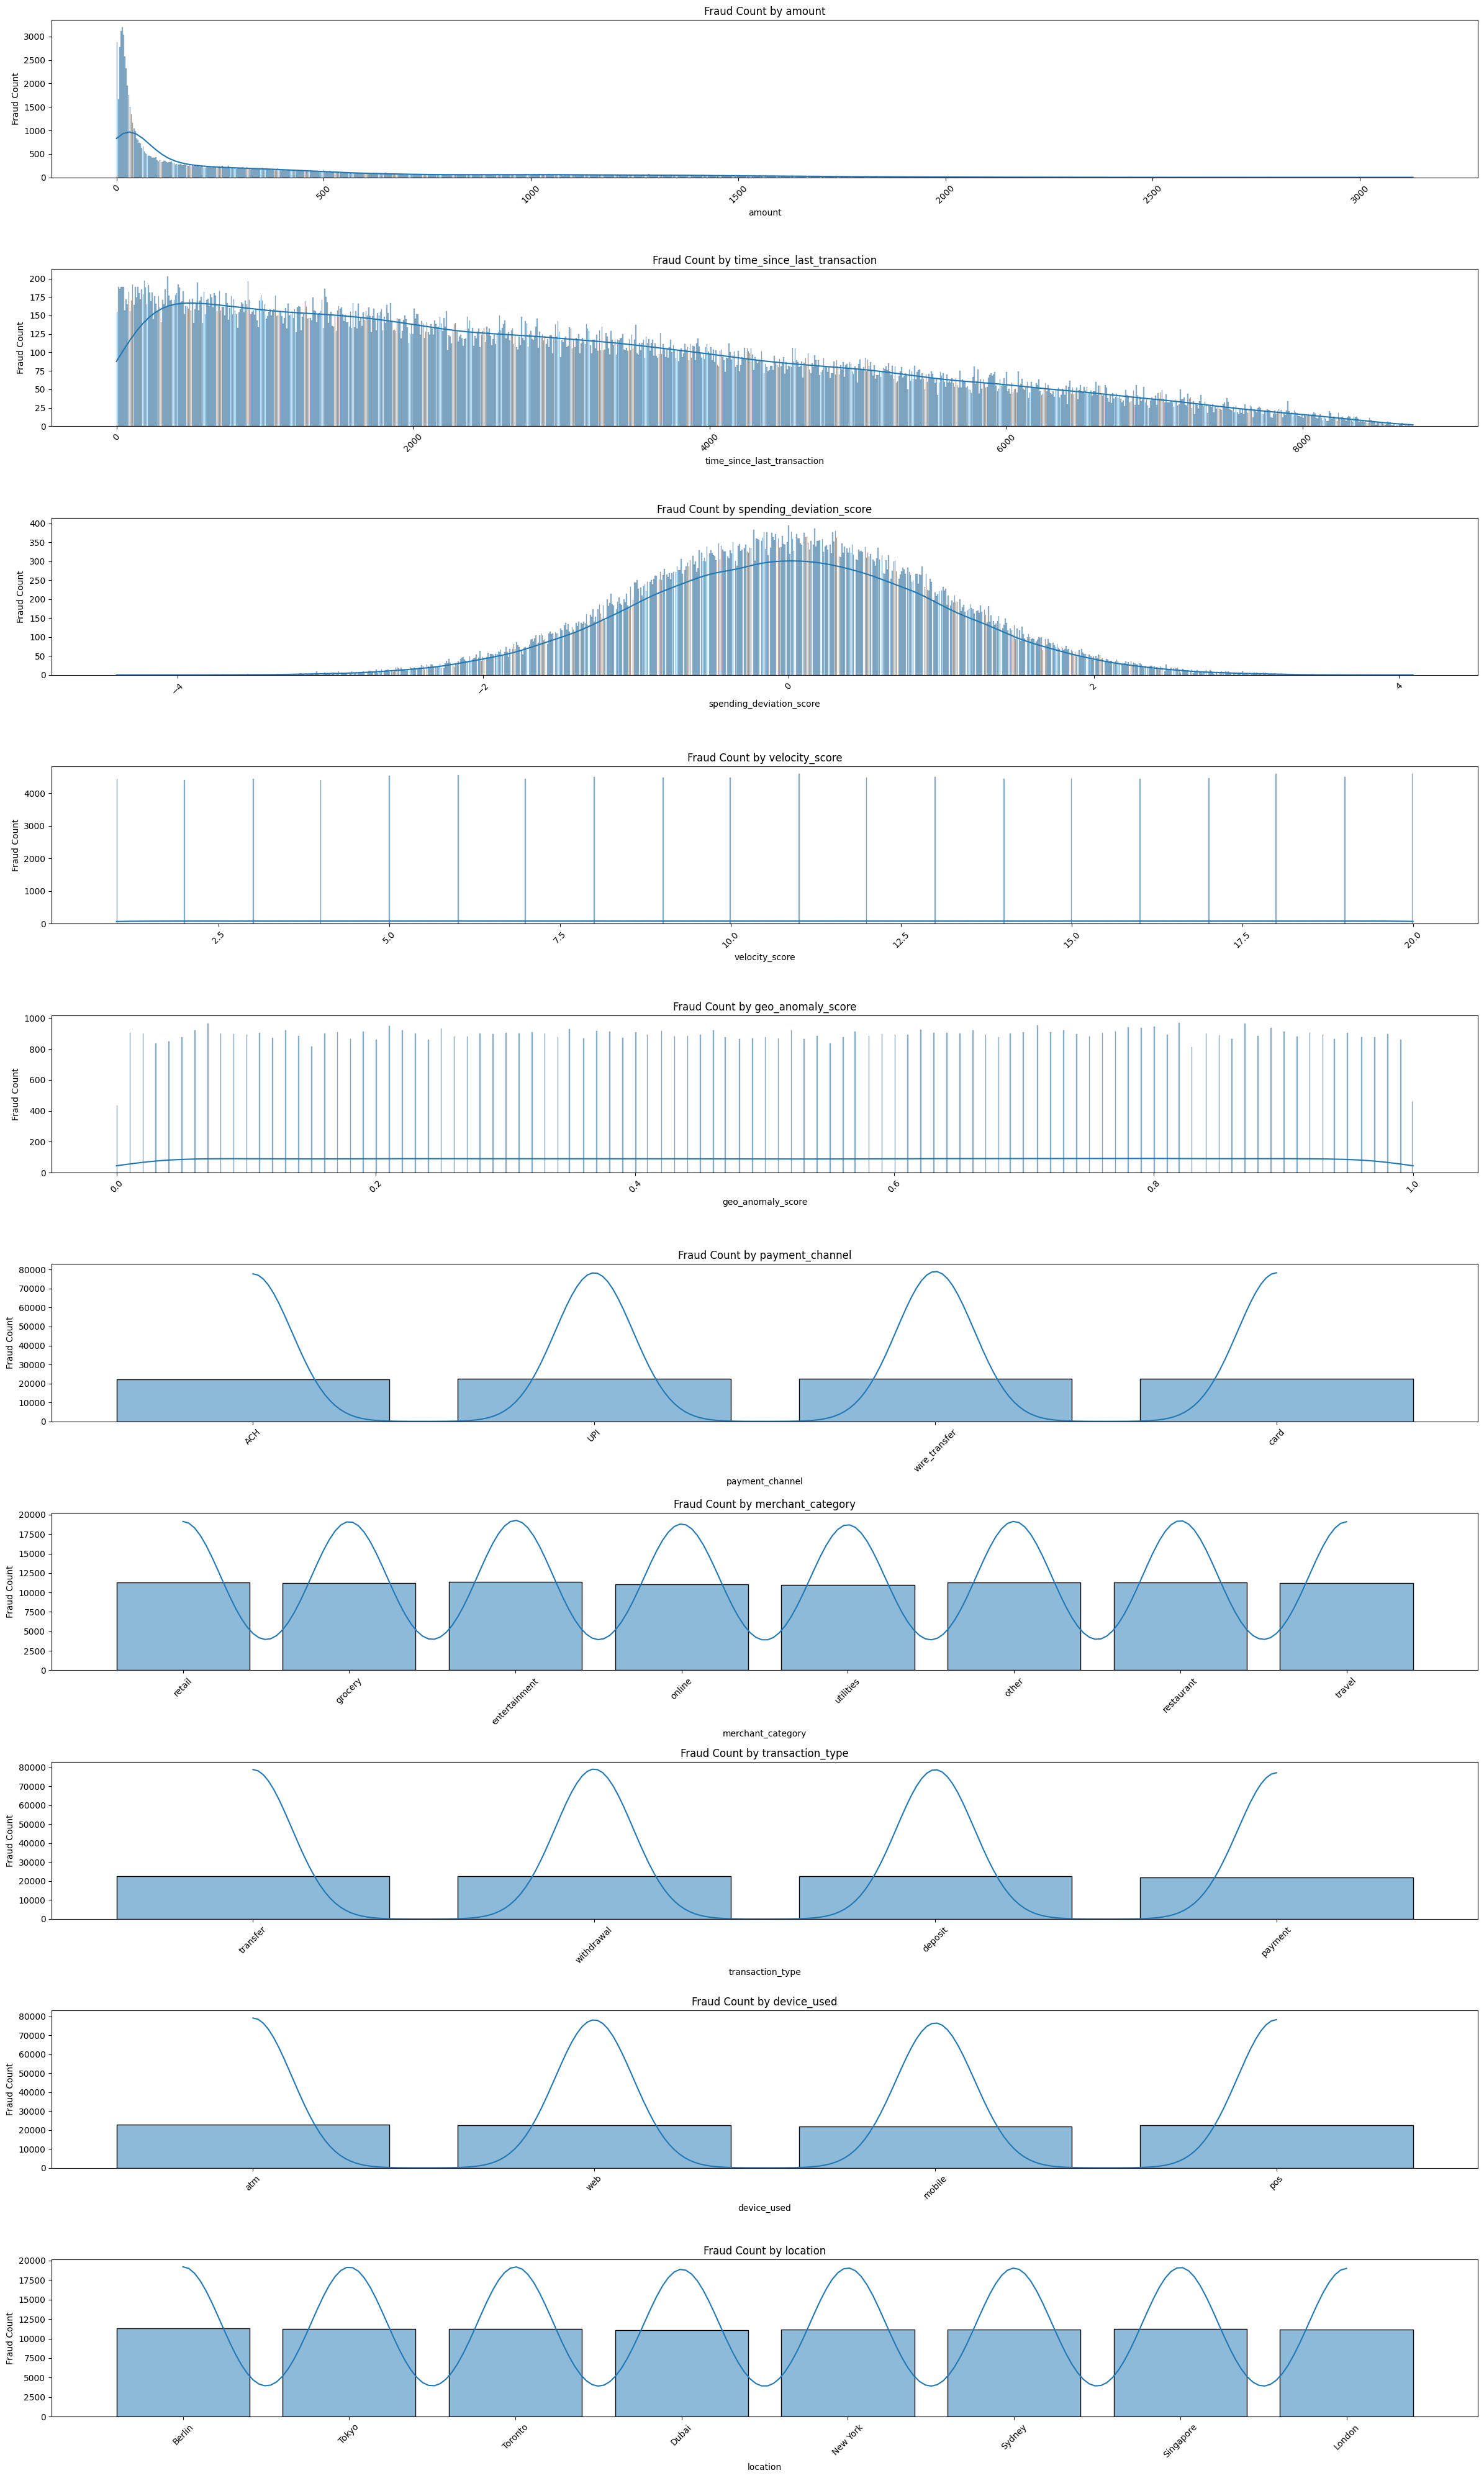

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

fraud_df = data_frame[data_frame['is_fraud'] == 1]

features = ['amount', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score', 'payment_channel', 'merchant_category', 'transaction_type', 'device_used', 'location']

plt.figure(figsize=(24, 40))

for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.histplot(
        data=fraud_df,
        x=feature,
        bins=1000,
        shrink=0.8,
        kde=True
    )
    plt.title(f"Fraud Count by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Fraud Count")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [101]:
data_frame['amount_bin'] = pd.qcut(data_frame['amount'], q=4, labels=['lowAmt','medAmt','highAmt','veryHighAmt'])
data_frame['time_bin'] = pd.cut(data_frame['time_since_last_transaction'], bins=[0, 60, 3600, float('inf')], labels=['shortGap','medGap','longGap'])
data_frame['spend_dev_bin'] = pd.cut(data_frame['spending_deviation_score'], bins=[-float('inf'), 0, 1, 3, 10], labels=['lowSpend', 'normalSpend','medSpendDev','highSpendDev'])

features = [
    'amount_bin','time_bin','spend_dev_bin'
]

# Add fraud as item
data_frame['fraud_flag'] = data_frame['is_fraud'].apply(lambda x: 'Fraud' if x==1 else 'Legit')

In [102]:
transactions = data_frame[features + ['fraud_flag']].astype(str).values.tolist()

te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_data, columns=te.columns_)

df_trans.shape
df_trans.head()

,Fraud,Legit,highAmt,highSpendDev,longGap,lowAmt,lowSpend,medAmt,medGap,medSpendDev,normalSpend,shortGap,veryHighAmt
0,True,False,False,False,False,True,False,False,True,False,True,False,False
1,True,False,True,False,False,False,True,False,True,False,False,False,False
2,True,False,False,False,True,False,True,False,False,False,False,False,True
3,True,False,False,False,False,False,True,True,True,False,False,False,False
4,True,False,False,False,True,True,True,False,False,False,False,False,False


In [103]:
min_support = 0.1
min_confidence = 0.4

In [104]:
frequent_itemsets_apriori = apriori(df_trans, min_support=min_support, use_colnames=True)

frequent_itemsets_apriori.sort_values(by='support', ascending=True).head(30)

,support,itemsets
26,0.109816,"(Legit, veryHighAmt)"
21,0.110153,"(Legit, lowAmt)"
19,0.110185,"(Legit, highAmt)"
23,0.110515,"(Legit, medAmt)"
30,0.117489,"(longGap, normalSpend)"
40,0.122547,"(Fraud, medGap, normalSpend)"
35,0.124886,"(lowSpend, veryHighAmt)"
33,0.125061,"(lowSpend, medAmt)"
31,0.125129,"(lowAmt, lowSpend)"
27,0.126658,"(lowSpend, highAmt)"


In [105]:
frequent_itemsets_fpgrowth = fpgrowth(df_trans, min_support=min_support, use_colnames=True)

frequent_itemsets_fpgrowth.sort_values(by='support', ascending=True).head(30)

,support,itemsets
34,0.109816,"(Legit, veryHighAmt)"
20,0.110153,"(Legit, lowAmt)"
27,0.110185,"(Legit, highAmt)"
38,0.110515,"(Legit, medAmt)"
14,0.117489,"(longGap, normalSpend)"
16,0.122547,"(Fraud, medGap, normalSpend)"
32,0.124886,"(lowSpend, veryHighAmt)"
37,0.125061,"(lowSpend, medAmt)"
19,0.125129,"(lowAmt, lowSpend)"
26,0.126658,"(lowSpend, highAmt)"


In [106]:
# Generate rules
apriori_rules = association_rules(df=frequent_itemsets_apriori, df_orig=df_trans, metric="confidence", min_threshold=min_confidence)
fpgrowth_rules = association_rules(df=frequent_itemsets_fpgrowth, df_orig=df_trans, metric="confidence", min_threshold=min_confidence)

fraud_apriori_rules = apriori_rules[apriori_rules['consequents'] == frozenset({'Fraud'})]
fraud_apriori_rules = fraud_apriori_rules.drop(['antecedent support', 'consequent support', 'support', 'representativity', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'certainty', 'kulczynski'], axis=1)

fraud_fpgrowth_rules = fpgrowth_rules[fpgrowth_rules['consequents'] == frozenset({'Fraud'})]
fraud_fpgrowth_rules = fraud_fpgrowth_rules.drop(['antecedent support', 'consequent support', 'support', 'representativity', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'certainty', 'kulczynski'], axis=1)

print('Apriori Algorithm')
print(fraud_apriori_rules.sort_values(by="confidence", ascending=False).head(30))

print()
print('FP-Growth Algorithm')
print(fraud_fpgrowth_rules.sort_values(by="confidence", ascending=False).head(30))

Apriori Algorithm
              antecedents consequents  confidence      lift
36  (medGap, normalSpend)     (Fraud)    0.560878  1.002767
9           (veryHighAmt)     (Fraud)    0.560740  1.002519
8           (normalSpend)     (Fraud)    0.560478  1.002052
7                (medGap)     (Fraud)    0.559624  1.000524
2                (lowAmt)     (Fraud)    0.559403  1.000130
0               (highAmt)     (Fraud)    0.559245  0.999848
1               (longGap)     (Fraud)    0.559144  0.999667
34     (lowSpend, medGap)     (Fraud)    0.559003  0.999414
4              (lowSpend)     (Fraud)    0.558722  0.998911
5                (medAmt)     (Fraud)    0.557934  0.997503

FP-Growth Algorithm
              antecedents consequents  confidence      lift
6   (medGap, normalSpend)     (Fraud)    0.560878  1.002767
25          (veryHighAmt)     (Fraud)    0.560740  1.002519
3           (normalSpend)     (Fraud)    0.560478  1.002052
1                (medGap)     (Fraud)    0.559624  1.000524
8